<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [42]:
from bs4 import BeautifulSoup
import requests
import os
##### Your Code Here #####
df = pd.read_csv(os.getcwd() + "/data/job_listings.csv")
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [60]:
def clean_html(df_input):
    return df_html.apply(lambda text: BeautifulSoup(text, 'html.parser').get_text()[2:-1])

texts = clean_html(df['description']).to_list()
texts[0]

"Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster's degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"

## 2) Use Spacy to tokenize the listings 

In [71]:
##### Your Code Here #####
nlp = spacy.load("en_core_web_lg")
tokens = [nlp(text).text for text in texts]
tokens[0]

"Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster's degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"

In [72]:
type(tokens[0])

str

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [74]:
##### Your Code Here #####
# list of text documents
text_01 = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet."," In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma."," This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vect = CountVectorizer()

# build vocab
vect.fit(tokens)

# # transform text
dtm = vect.transform(tokens)

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.

# The vocabulary dictionary does not represent the counts of words!!


In [79]:
print(vect.get_feature_names()[:10])

['00', '000', '02115', '03', '0356', '04', '062', '06366', '08', '10']


In [80]:
print(dtm)

  (0, 225)	1
  (0, 498)	1
  (0, 569)	2
  (0, 608)	2
  (0, 661)	1
  (0, 675)	1
  (0, 697)	1
  (0, 755)	1
  (0, 914)	1
  (0, 1071)	1
  (0, 1472)	1
  (0, 1528)	1
  (0, 1612)	1
  (0, 1689)	1
  (0, 2071)	1
  (0, 2132)	1
  (0, 2167)	1
  (0, 2482)	1
  (0, 2616)	1
  (0, 2848)	1
  (0, 2960)	2
  (0, 2977)	1
  (0, 3133)	1
  (0, 3160)	1
  (0, 3249)	1
  :	:
  (425, 9654)	1
  (425, 9690)	1
  (425, 9711)	1
  (425, 9759)	1
  (425, 9783)	2
  (425, 9820)	1
  (425, 9826)	1
  (425, 9828)	1
  (425, 9834)	2
  (425, 9847)	3
  (425, 9849)	1
  (425, 9863)	10
  (425, 9865)	2
  (425, 9866)	1
  (425, 9876)	6
  (425, 9882)	1
  (425, 9885)	1
  (425, 9888)	1
  (425, 9911)	5
  (425, 9924)	2
  (425, 9960)	3
  (425, 10028)	5
  (425, 10041)	2
  (425, 10052)	3
  (425, 10054)	1


In [81]:
# deal with sparse mtx
dtm.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]])

In [82]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [83]:
# Get Word Counts for each document
df_dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
df_dtm

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [90]:
# reference: https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

sum_words = dtm.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:10]

[('and', 11737),
 ('to', 6913),
 ('the', 5300),
 ('of', 4611),
 ('data', 4394),
 ('in', 3594),
 ('with', 3059),
 ('for', 2059),
 ('or', 1936),
 ('you', 1505)]

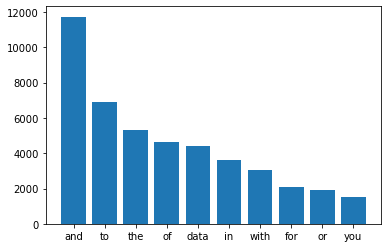

In [104]:
plt.bar([word[0] for word in words_freq[:10]], [word[1] for word in words_freq[:10]], align='center')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [110]:
##### Your Code Here #####
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(tokens)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.sample(20)

,000,04,10,100,1079302,11,12,125,14,15,...,yes,yeti,york,young,yrs,zero,zeus,zf,zillow,zuckerberg
363,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
96,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
391,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
310,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
246,0.045487,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
94,0.050476,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
178,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
193,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
83,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
196,0.000000,0.0,0.000000,0.027469,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [111]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree')

In [112]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.28186048, 1.2923534 , 1.29554001, 1.30351552]]),
 array([[  0, 336, 276, 274, 366]]))

In [117]:
tokens[0][:200]

'Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along '

In [116]:
tokens[336][:200]

'Discover business insights, identify opportunities and provide solutions and recommendations to solve business problems through the use of statistical, algorithmic, data mining and visualization techn'

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 